In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
# Source: http://web.mta.info/developers/turnstile.html
#Using data from Aril 2019 to estimate ridership in alternate non-Covid April 2020 world
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190406, 190413, 190420]
turnstiles_df = get_data(week_nums)

In [5]:
#standardize column names
turnstiles_df.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)   

In [6]:
#change Date and Time to Datetime
turnstiles_df['DATE/TIME'] = turnstiles_df.DATE + ' ' + turnstiles_df.TIME 

In [7]:
turnstiles_df.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE/TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568,03/30/2019 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,03/30/2019 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622,03/30/2019 08:00:00


In [8]:
#change Date and Time to Datetime
turnstiles_df[["DATE/TIME"]] = turnstiles_df[["DATE/TIME"]].apply(pd.to_datetime)

In [9]:
turnstiles_df.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE/TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568,2019-03-30 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,2019-03-30 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622,2019-03-30 08:00:00


In [10]:
turnstiles_df['change_in_entries']=turnstiles_df.ENTRIES.diff()

In [11]:
turnstiles_df.change_in_entries.isna().sum()

1

In [12]:
# changing the NaN in row 0 to 0 because that is the start of our period so there are no entries yet
turnstiles_df = turnstiles_df.fillna(0)

In [13]:
#removing outliers step #1 (100,000 entries in a 4 hour period is too high for any one turnstile. These values seem 
# to be caused by reseting of the entries counter. We are making this zero to minimize this impact on the data)

turnstiles_df.loc[abs(turnstiles_df.change_in_entries) > 100000, 'change_in_entries'] = 0

In [14]:
#removing outliers step #2 (Negative values don't make sense because you cannot have negative entries. We think this
# may be caused by either the counting happening backwards or due to resetting of the entries counter. Either way, 
# we also feel like these values should be removed as well)

turnstiles_df.loc[turnstiles_df.change_in_entries < 0] = 0

In [15]:
#removing outliers step #3 (We grabbed data from 3/30/19 to 4/19/19. So since 3/30/19 is the beginning of 
# our period, at 00:00:00 on that date there should be no entries)


turnstiles_df.loc[(turnstiles_df['DATE'] == '03/30/2019') & (turnstiles_df['TIME'] == '00:00:00'),'change_in_entries'] = 0

In [16]:
#by day
total_entries=turnstiles_df.groupby(['STATION','DATE']).sum()

In [17]:
total_entries.head(10)

ENTRIES       EXITS  change_in_entries
STATION DATE                                                 
0       0                    0           0                0.0
1 AV    03/30/2019  8476902750  8777601464            11546.0
        03/31/2019  8476991287  8777700425            13061.0
        04/01/2019  8477074574  8777796016            19144.0
        04/02/2019  8477193734  8777929269            19998.0
        04/03/2019  8477316997  8778064036            20915.0
        04/04/2019  8477445695  8778198027            21740.0
        04/05/2019  9436464054  9798096741            22173.0
        04/06/2019  8477700346  8778480585            12884.0
        04/07/2019  8477794429  8778593454            13593.0

In [18]:
rowData = total_entries.loc[ '86 ST' , : ]

In [19]:
rowData

,ENTRIES,EXITS,change_in_entries
DATE,,,
03/30/2019,11405951756,14551870894,137237.0
03/31/2019,8487978551,13646733310,41210.0
04/01/2019,8488308615,13647032223,79438.0
04/02/2019,8488807362,13647474942,86147.0
04/03/2019,8489329421,13647933746,86997.0
04/04/2019,8489849763,13648394145,86512.0
04/05/2019,8464619769,13635901198,83073.0
04/06/2019,9463369432,13950848286,237547.0
04/07/2019,8491101683,13649565135,43087.0


In [20]:
three_week_total=total_entries.groupby(['STATION']).sum()

In [21]:
three_week_total

,ENTRIES,EXITS,change_in_entries
STATION,,,
0,0,0,0.0
1 AV,179376540677,185764592153,379254.0
103 ST,26999668707,80664437710,547948.0
103 ST-CORONA,8901207208,8974629779,378726.0
104 ST,190354543306,262812455795,74480.0
...,...,...,...
WOODLAWN,3801398794,1489562246,126558.0
WORLD TRADE CTR,201210302451,231898370390,359731.0
WTC-CORTLANDT,93154800376,232496108,1307186.0


In [22]:
#data from 59 ST station
station_59=turnstiles_df.loc[(turnstiles_df['C/A']=='A002') 
                             & (turnstiles_df['UNIT']=='R051') 
                             & (turnstiles_df['SCP']=='02-00-00')
                             & (turnstiles_df['STATION']=='59 ST')]

In [23]:
%matplotlib inline

<Figure size 720x216 with 0 Axes>

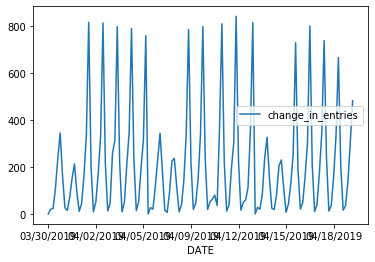

In [24]:
# plotting a time series for this turnstile at the 59 ST station

#one station plot 
plt.figure(figsize=(10,3))
station_59.plot('DATE','change_in_entries')

In [25]:
total_riders=three_week_total.sort_values('change_in_entries',ascending=False)

In [26]:
top_twenty=total_riders.head(20)

In [27]:
top_twenty

,ENTRIES,EXITS,change_in_entries
STATION,,,
34 ST-PENN STA,479796209516,373720395765,3489847.0
GRD CNTRL-42 ST,222784889216,313429852376,2672159.0
PATH NEW WTC,608011032,731306247,2386118.0
23 ST,543277562853,614763150832,2364838.0
14 ST-UNION SQ,88704284202,46273541662,2230043.0
34 ST-HERALD SQ,274719583612,252378844788,2113783.0
86 ST,184423412575,290431151077,2021449.0
TIMES SQ-42 ST,513268034993,404983470057,1917305.0
CANAL ST,331832597278,489615104634,1746302.0


In [28]:
total_riders.head(20)

,ENTRIES,EXITS,change_in_entries
STATION,,,
34 ST-PENN STA,479796209516,373720395765,3489847.0
GRD CNTRL-42 ST,222784889216,313429852376,2672159.0
PATH NEW WTC,608011032,731306247,2386118.0
23 ST,543277562853,614763150832,2364838.0
14 ST-UNION SQ,88704284202,46273541662,2230043.0
34 ST-HERALD SQ,274719583612,252378844788,2113783.0
86 ST,184423412575,290431151077,2021449.0
TIMES SQ-42 ST,513268034993,404983470057,1917305.0
CANAL ST,331832597278,489615104634,1746302.0


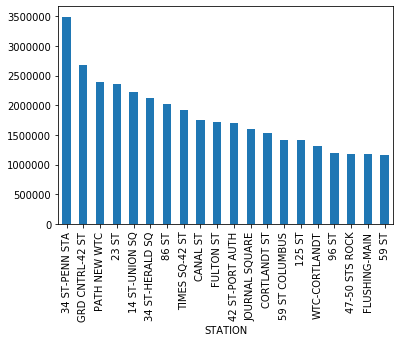

In [29]:
top_twenty['change_in_entries'].plot.bar()